Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from collections import Counter

import joblib

sns.set_style("whitegrid")
print("All libraries imported successfully!")

All libraries imported successfully!


 Load Preprocessing Data

In [2]:
from pathlib import Path

BASE_DIR = Path.cwd().parent
df = pd.read_csv(BASE_DIR / "data" / "cleaned_fake_job_postings.csv")

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nClass distribution:")
print(df['fraudulent'].value_counts())
print(f"\nClass distribution (%):")
print(df['fraudulent'].value_counts(normalize=True) * 100)

df.head()

Dataset loaded successfully!
Shape: (17880, 2)

Class distribution:
fraudulent
0    17014
1      866
Name: count, dtype: int64

Class distribution (%):
fraudulent
0    95.1566
1     4.8434
Name: proportion, dtype: float64


,clean_text,fraudulent
0,marketing intern marketing food fast growing j...,0
1,customer service cloud video production succes...,0
2,commissioning machinery assistant cma client l...,0
3,account executive washington sale company esri...,0
4,bill review manager job title itemization revi...,0


TF IDF Vectorization

In [3]:
print("Vectorizing text using TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1, 2),
    min_df=2,  
    max_df=0.95  
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['fraudulent']

print(f"Vectorization complete!")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")
print(f"Matrix sparsity: {(1 - X.nnz / (X.shape[0] * X.shape[1])) * 100:.2f}%")

Vectorizing text using TF-IDF...
Vectorization complete!
Feature matrix shape: (17880, 5000)
Number of features: 5000
Matrix sparsity: 97.19%


Train-Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Train-Test Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nBefore SMOTE - Training set class distribution:")
print(Counter(y_train))
print(f"Imbalance ratio: {Counter(y_train)[0] / Counter(y_train)[1]:.2f}:1")

Train-Test Split:
Training set: 14304 samples
Test set: 3576 samples

Before SMOTE - Training set class distribution:
Counter({0: 13611, 1: 693})
Imbalance ratio: 19.64:1


Applying SMOTE on Training Set

In [5]:
print("Applying SMOTE to balance training data...")

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"\nSMOTE applied successfully!")
print(f"After SMOTE - Training set class distribution:")
print(Counter(y_resampled))
print(f"New training set size: {X_resampled.shape[0]} samples")

Applying SMOTE to balance training data...

SMOTE applied successfully!
After SMOTE - Training set class distribution:
Counter({0: 13611, 1: 13611})
New training set size: 27222 samples


Train XGBoost model

In [6]:
print("Training XGBoost model...")
print("This may take a few minutes...\n")

model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    random_state=42,
    n_estimators=100,  
    max_depth=6,       
    learning_rate=0.1,
    subsample=0.8,     
    colsample_bytree=0.8 
)

model.fit(X_resampled, y_resampled)

print("Model training complete!")

Training XGBoost model...
This may take a few minutes...



d:\fake-job-detector-using-nlp\venv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model training complete!


Evaluate Model on Real Test Set

Evaluating model on test set...

ACCURACY: 0.9782 (97.82%)

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      3403
        Fake       0.84      0.68      0.75       173

    accuracy                           0.98      3576
   macro avg       0.91      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576



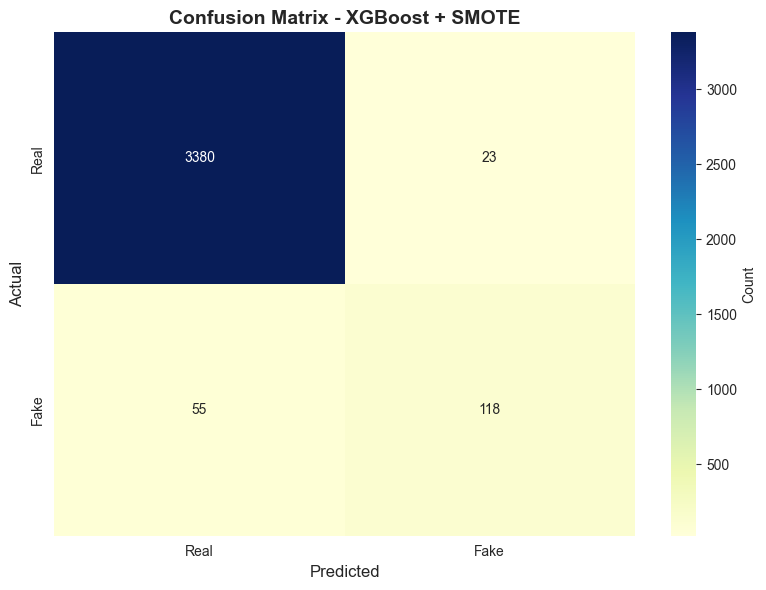


Confusion Matrix Breakdown:
True Negatives (Real predicted as Real): 3380
False Positives (Real predicted as Fake): 23
False Negatives (Fake predicted as Real): 55
True Positives (Fake predicted as Fake): 118


In [7]:
print("Evaluating model on test set...\n")

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("="*50)
print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
print("="*50)

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'})
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - XGBoost + SMOTE", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Real predicted as Real): {tn}")
print(f"False Positives (Real predicted as Fake): {fp}")
print(f"False Negatives (Fake predicted as Real): {fn}")
print(f"True Positives (Fake predicted as Fake): {tp}")

Saving the Model and Vectorizer

In [8]:
from pathlib import Path

print("Saving model and vectorizer...")

PROJECT_ROOT = Path.cwd().parent

model_dir = PROJECT_ROOT / "models"
app_dir = PROJECT_ROOT / "app"

model_dir.mkdir(parents=True, exist_ok=True)
app_dir.mkdir(parents=True, exist_ok=True)

model_path = model_dir / "xgb_fake_job_model.pkl"
vectorizer_path = model_dir / "tfidf_vectorizer.pkl"

joblib.dump(model, model_path)
joblib.dump(vectorizer, vectorizer_path)

print(f"Model saved to: {model_path}")
print(f"Vectorizer saved to: {vectorizer_path}")

app_model_path = app_dir / "xgb_fake_job_model.pkl"
app_vectorizer_path = app_dir / "tfidf_vectorizer.pkl"

joblib.dump(model, app_model_path)
joblib.dump(vectorizer, app_vectorizer_path)

print("\nCopies saved to app folder:")
print(f"   - {app_model_path}")
print(f"   - {app_vectorizer_path}")

print("\nVerifying saved files...")
for path in [model_path, vectorizer_path, app_model_path, app_vectorizer_path]:
    if path.exists():
        size_kb = path.stat().st_size / 1024
        print(f"{path.name}: {size_kb:.2f} KB")
    else:
        print(f"{path.name}: NOT FOUND")


Saving model and vectorizer...
Model saved to: d:\fake-job-detector-using-nlp\models\xgb_fake_job_model.pkl
Vectorizer saved to: d:\fake-job-detector-using-nlp\models\tfidf_vectorizer.pkl

Copies saved to app folder:
   - d:\fake-job-detector-using-nlp\app\xgb_fake_job_model.pkl
   - d:\fake-job-detector-using-nlp\app\tfidf_vectorizer.pkl

Verifying saved files...
xgb_fake_job_model.pkl: 256.57 KB
tfidf_vectorizer.pkl: 178.24 KB
xgb_fake_job_model.pkl: 256.57 KB
tfidf_vectorizer.pkl: 178.24 KB


Top Features

Analyzing feature importance...

TOP 20 PREDICTIVE WORDS FOR FAKE/REAL JOBS
 1. experience required  → 0.034445
 2. data entry           → 0.025899
 3. oil                  → 0.020117
 4. home                 → 0.019446
 5. income               → 0.016070
 6. written              → 0.014558
 7. per                  → 0.013732
 8. operation            → 0.012130
 9. solve                → 0.011997
10. car                  → 0.011312
11. infrastructure       → 0.010693
12. along                → 0.010405
13. others               → 0.010050
14. must experience      → 0.009394
15. admin                → 0.009208
16. duty                 → 0.008800
17. responsibility       → 0.008755
18. corporate            → 0.008136
19. integral part        → 0.007615
20. include              → 0.007081


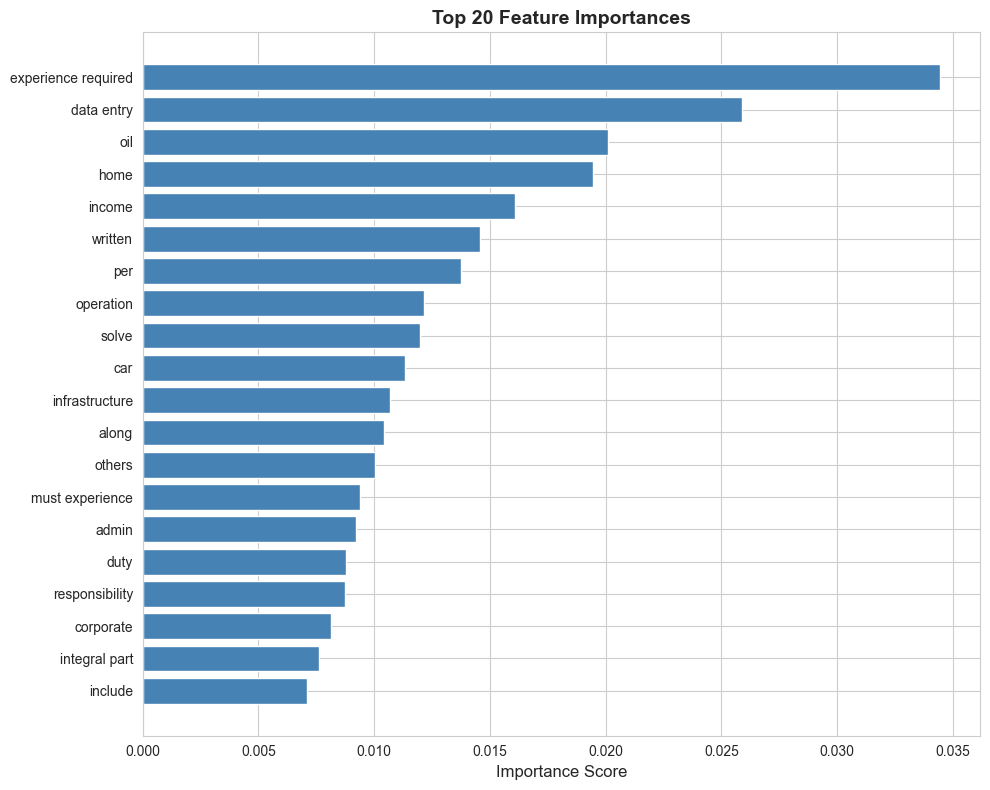


Feature importance analysis complete!


In [9]:
print("Analyzing feature importance...\n")

features = vectorizer.get_feature_names_out()
importances = model.feature_importances_

top_n = 20
top_idx = np.argsort(importances)[-top_n:][::-1]

print("="*60)
print("TOP 20 PREDICTIVE WORDS FOR FAKE/REAL JOBS")
print("="*60)

top_features_data = []
for rank, idx in enumerate(top_idx, 1):
    feature_name = features[idx]
    importance = importances[idx]
    print(f"{rank:2d}. {feature_name:20s} → {importance:.6f}")
    top_features_data.append((feature_name, importance))

fig, ax = plt.subplots(figsize=(10, 8))
feature_names = [features[i] for i in top_idx]
feature_importances = [importances[i] for i in top_idx]

ax.barh(range(len(feature_names)), feature_importances, color='steelblue')
ax.set_yticks(range(len(feature_names)))
ax.set_yticklabels(feature_names)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_title('Top 20 Feature Importances', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature importance analysis complete!")

Testing

In [10]:
print("Testing saved model...")

loaded_model = joblib.load(model_path)
loaded_vectorizer = joblib.load(vectorizer_path)

test_text = "work from home earn money fast no experience required"
test_vector = loaded_vectorizer.transform([test_text])
prediction = loaded_model.predict(test_vector)[0]
proba = loaded_model.predict_proba(test_vector)[0]

print(f"\nTest input: '{test_text}'")
print(f"Prediction: {'FAKE' if prediction == 1 else 'REAL'}")
print(f"Confidence: {proba[prediction]*100:.2f}%")

print("\nModel and vectorizer are working correctly!")
print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)
print(f"Models saved in: {model_dir}")
print(f"App copies in: {app_dir}")
print(f"Accuracy: {accuracy*100:.2f}%")
print("="*60)

Testing saved model...

Test input: 'work from home earn money fast no experience required'
Prediction: REAL
Confidence: 61.15%

Model and vectorizer are working correctly!

MODEL TRAINING COMPLETE!
Models saved in: d:\fake-job-detector-using-nlp\models
App copies in: d:\fake-job-detector-using-nlp\app
Accuracy: 97.82%
